In [1]:
import matplotlib.pyplot as plt
import polars as pl
import util
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import osmnx as ox
import numpy as np

In [17]:
# df = util.load_data().fetch(500_000)
# df = util.load_data().collect()

# Run preprocess.py to obtain the parquet dataset
df = pl.read_parquet('datasets/train.parquet')
df.head()

fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
f64,datetime[μs],f64,f64,f64,f64,i64
4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.84161,40.712278,1
16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
5.7,2011-08-18 00:35:00,-73.982738,40.76127,-73.991242,40.750562,2
7.7,2012-04-21 04:30:42,-73.98713,40.733143,-73.991567,40.758092,1
5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


In [3]:
df.shape

(54026820, 7)

## Data distribution

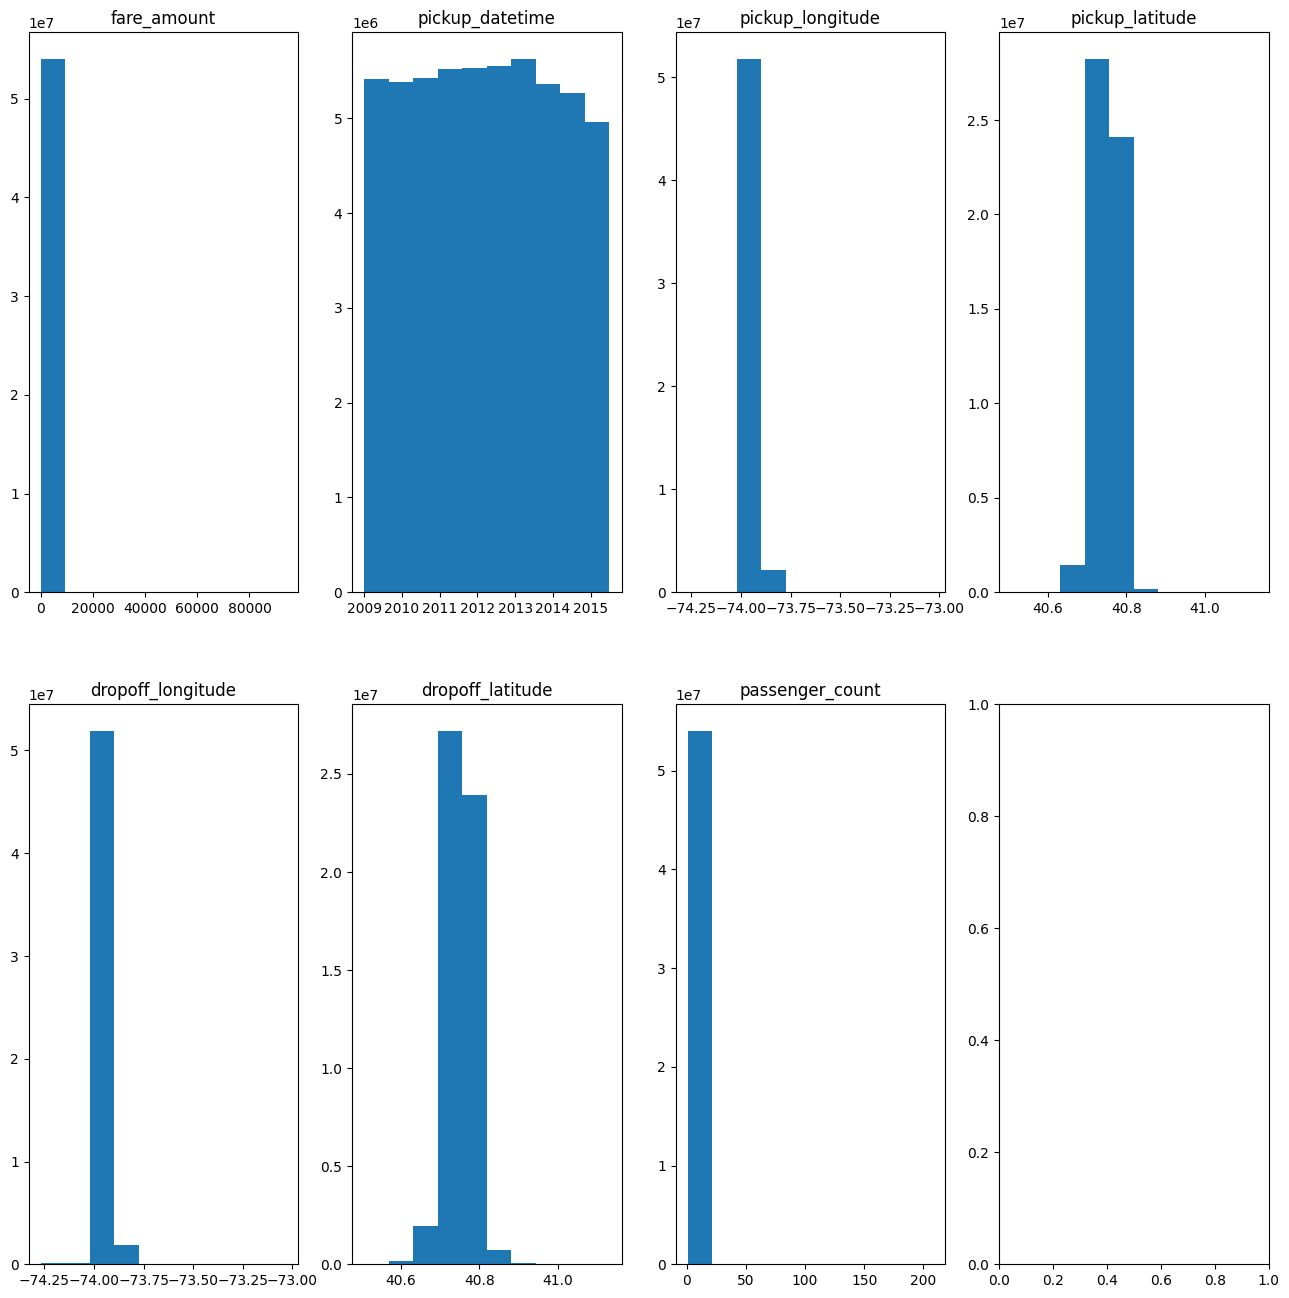

In [4]:
# NB: This plot takes a lot of time
util.plot_distributions(df)

The distributions suggest the existence of unrealistic data (noise?) and outliers (hundres of passengers for one run, thosands of dollars for a single run). Min and max values show this very clearly. Before moving on with other statistics, it may be a good idea to clear the data further.

In [5]:
pl.concat((df.min(), df.max()))

fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
f64,datetime[μs],f64,f64,f64,f64,i64
0.01,2009-01-01 00:00:27,-74.268085,40.506906,-74.268085,40.50683,1
93963.36,2015-06-30 23:59:54,-73.033332,41.130701,-73.031918,41.130642,208


### Passenger count
According to the [NYC taxi commission](https://www.nyc.gov/site/tlc/passengers/passenger-frequently-asked-questions.page#:~:text=The%20maximum%20amount%20of%20passengers,of%20an%20adult%20passenger%20seated) the maximum number of passengers, for suitable vehicles, is five. An additional sixth person (child) is admitted. Thus, it is possible to consider all samples that exceed the number of six passengers to be noise. In fact, values greater than six are highly underrepresented.

In [18]:
df.groupby('passenger_count').agg(pl.count()).sort('passenger_count')

passenger_count,count
i64,u32
1,37492675
2,8007654
3,2381249
4,1154838
5,3840257
6,1150083
7,13
8,7
9,20


In [19]:
df = df.filter(pl.col('passenger_count') <= 6)

## Analyzing spatial locations

In [12]:
train, test = train_test_split(df, test_size=0.2)
train, valid = train_test_split(train, test_size=0.2)

In [17]:
def print_point_on_map(ax, x, y, points_area, image_size, image, markersize=.5, color='b', title=None):
    x_min, x_max, y_min, y_max = points_area
    
    x_printable = image_size[0] * (x - x_min) / (x_max - x_min)
    y_printable = image_size[1] * (y - y_min) / (y_max - y_min)
    
    ax.imshow(image, extent=[0, image_size[0], 0, image_size[1]])
    ax.scatter(x_printable, y_printable, markersize, color)
    if title is not None:
        ax.title.set_text(str(title))

In [18]:
x = train['pickup_longitude'].append(train['dropoff_longitude'])
y = train['pickup_latitude'].append(train['dropoff_latitude'])
points_area = x.min(), x.max(), y.min(), y.max()
image_size = (434,300)
image = util.get_image_from_coordinate(points_area, image_size)



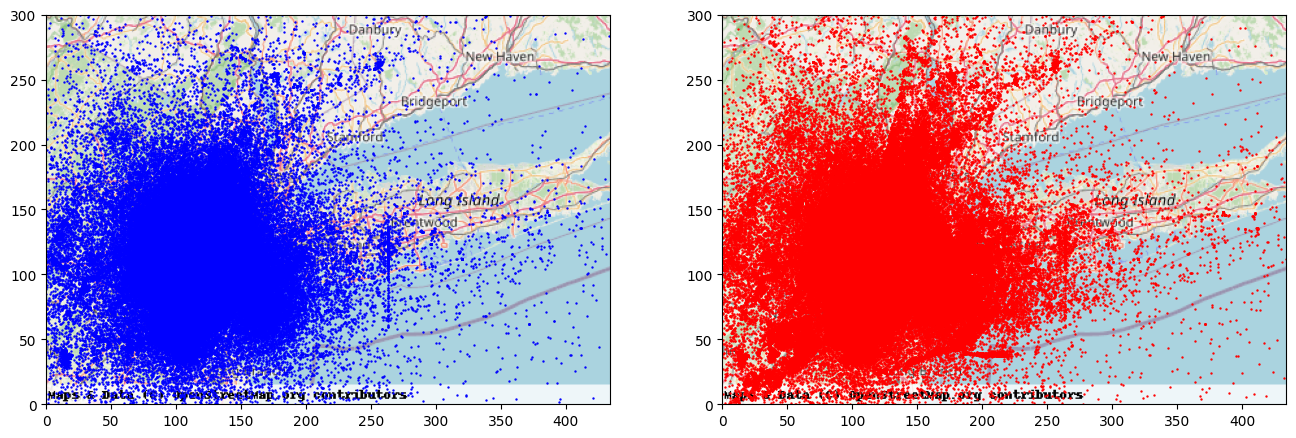

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(16, 16))
print_point_on_map(axs[0], train['pickup_longitude'], train['pickup_latitude'], points_area, image_size, image, color='b')
print_point_on_map(axs[1], train['dropoff_longitude'], train['dropoff_latitude'], points_area, image_size, image, color='r')

10754203 23822961


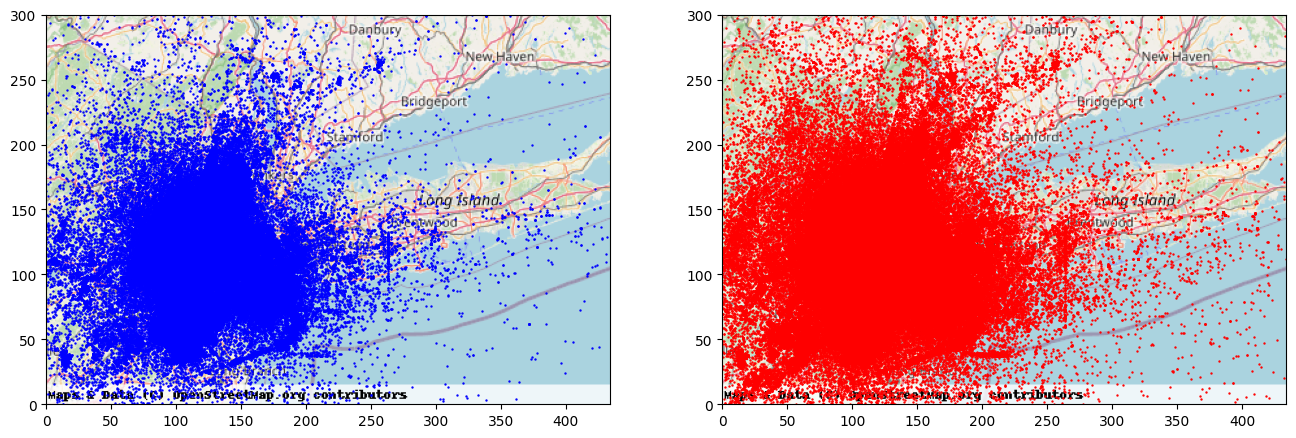

In [20]:
timezone = -5
lavorative_hours = (8, 18)

day_hours = train.filter((pl.col("pickup_datetime").dt.hour() > lavorative_hours[0]+timezone) & (pl.col("pickup_datetime").dt.hour() < lavorative_hours[1]+timezone))
night_hours = train.filter((pl.col("pickup_datetime").dt.hour() <= lavorative_hours[0]+timezone) | (pl.col("pickup_datetime").dt.hour() >= lavorative_hours[1]+timezone))

print(len(day_hours), len(night_hours))

x_day = day_hours['pickup_longitude'].append(day_hours['dropoff_longitude'])
y_day = day_hours['pickup_latitude'].append(day_hours['dropoff_latitude'])

x_night = night_hours['pickup_longitude'].append(night_hours['dropoff_longitude'])
y_night = night_hours['pickup_latitude'].append(night_hours['dropoff_latitude'])

fig, axs = plt.subplots(1, 2, figsize=(16, 16))
print_point_on_map(axs[0], x_day, y_day, points_area, image_size, image, color='b')
print_point_on_map(axs[1], x_night, y_night, points_area, image_size, image, color='r')

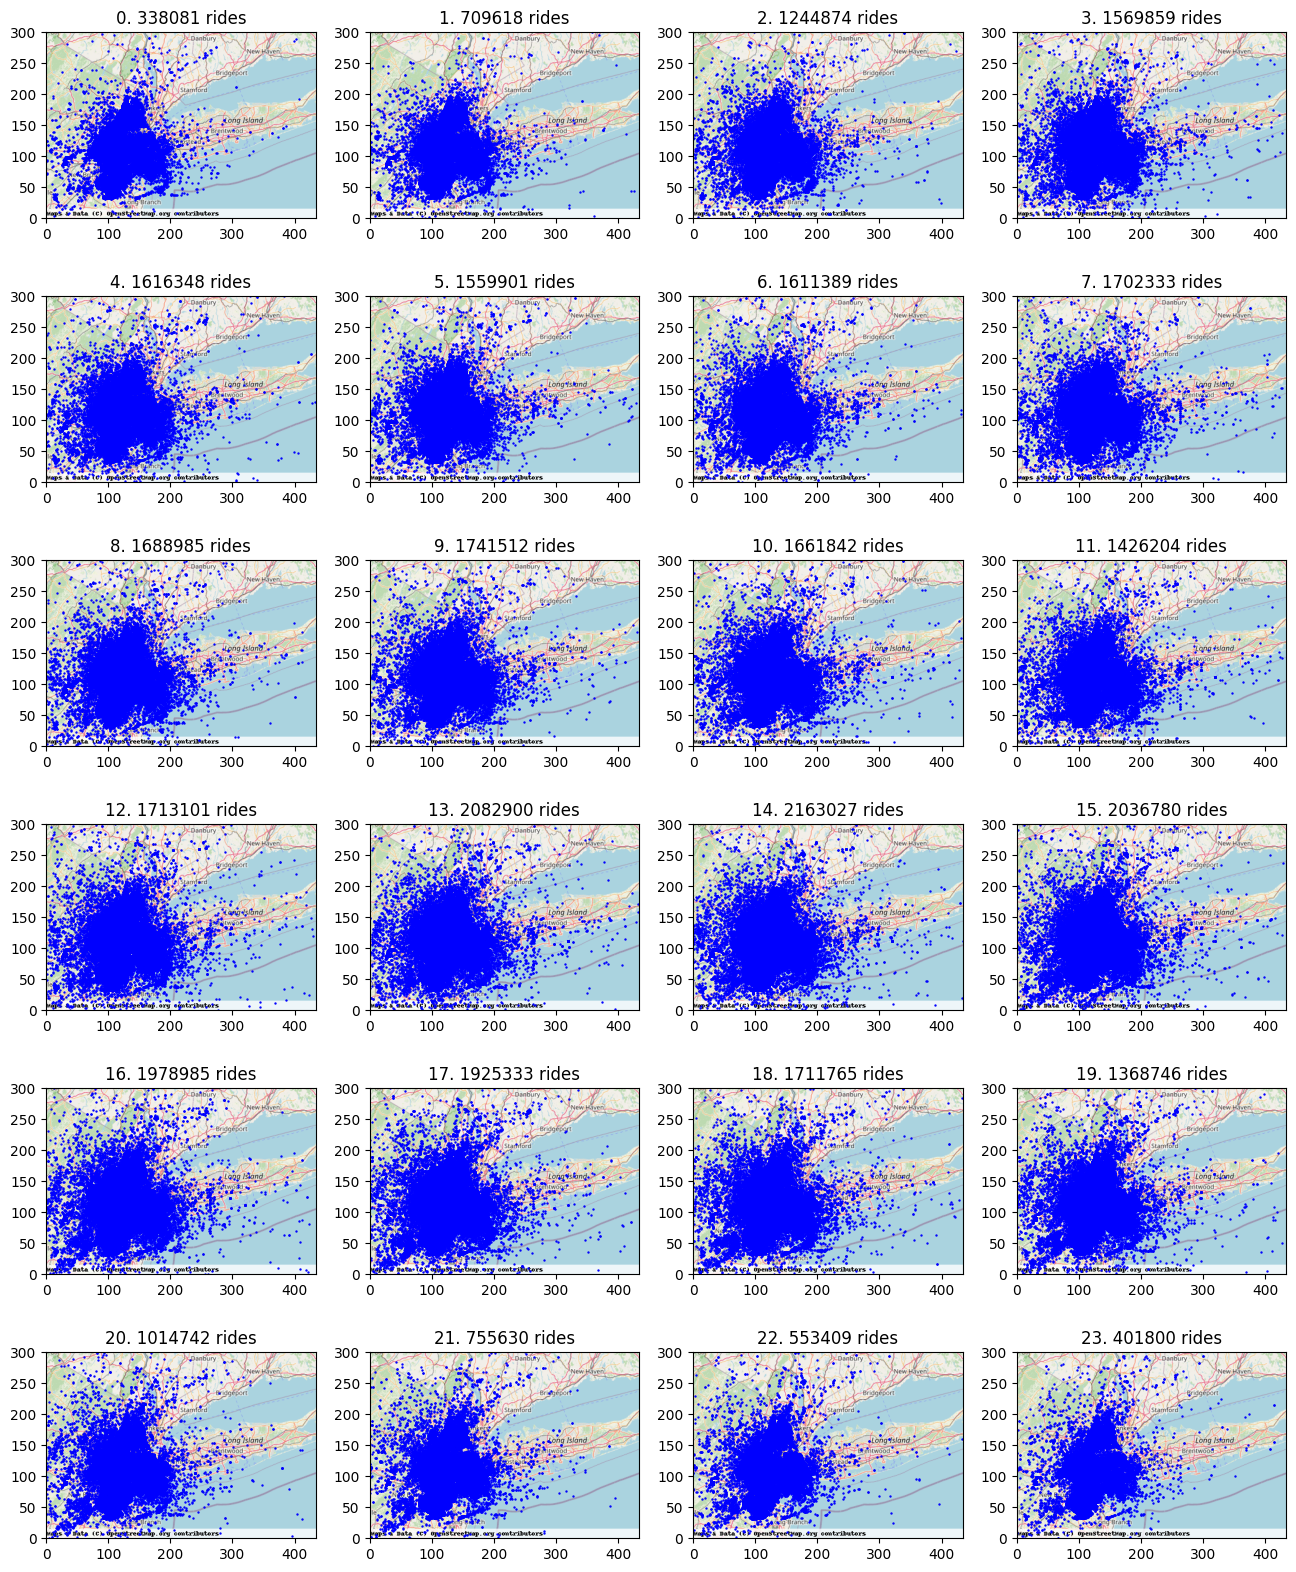

In [21]:
hours = []

for h in range(5,29):
    df = train.filter(pl.col("pickup_datetime").dt.hour() == h % 24)
    hours.append((df['pickup_longitude'].append(df['dropoff_longitude']),
                  df['pickup_latitude'].append(df['dropoff_latitude']),
                  len(df)))
    
fig, axs = plt.subplots(6, 4, figsize=(16, 20))
for h in range(24):
    print_point_on_map(axs[h//4, h % 4], hours[h][0], hours[h][1], points_area, image_size, image, color='b',
                       title=f'{(h) % 24}. {hours[h][2]} rides')

In [39]:
import importlib
importlib.reload(util)

<module 'util' from '/home/ballman/code/py/taxi/util.py'>